In [13]:
!pip install category_encoders
!pip install texthero
!pip install transformers
!pip install torch==1.5.0

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import model_selection

from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import BertTokenizer, BertModel

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub18/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
train_column = train_df.columns

In [5]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [6]:
train_df_drop = train_df[X_column]

In [7]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
#     df['User_Score'] = df['User_Score'].astype('float64')
#     df['User_Score'] = df['User_Score'].fillna(0)
    
    return df

In [8]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)
# test_df['Name'].fillna('noname', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
# plat_pivot = whole_df.pivot_table(index='Publisher', columns='Rating', values='User_Score', aggfunc=np.mean).reset_index()
# plat_pivot

In [10]:
def add_pub_dev_info(df1, df2, tgt, col, val, func='count'):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values=val, aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:3] +  '_' + col+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2

def add_pub_dev_info_sum(df1, df2, tgt, col, val, func=np.sum):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values=val, aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:3] +  '_' + col+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2

In [11]:
tgts = ['Publisher', 'Developer']
cols = ['Platform', 'Genre', 'Rating', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
for a_tgt in tgts:
    for a_col in cols:
        train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, a_tgt, a_col, 'Name')
        
# user_scoreだけできない
# vals = ['Critic_Score', 'Critic_Count',  'User_Count']
# tgts = ['Publisher', 'Developer']
# cols = ['Platform', 'Genre', 'Rating']
# count = 0
# for a_val in vals:
#     for a_tgt in tgts:
#         for a_col in cols:
#             train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, a_tgt, a_col, a_val)
#             count += 1
        

train_df_drop

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,...,Dev_Genre_User_Count_pca_0,Dev_Genre_User_Count_pca_1,Dev_Genre_User_Count_pca_2,Dev_Genre_User_Count_pca_3,Dev_Genre_User_Count_pca_4,Dev_Rating_User_Count_pca_0,Dev_Rating_User_Count_pca_1,Dev_Rating_User_Count_pca_2,Dev_Rating_User_Count_pca_3,Dev_Rating_User_Count_pca_4
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,74.0,17.0,7.9,22.0,Traveller's Tales,...,7.173848,53.944185,-2.108985,-7.218922,-4.530963,17.704573,7.731965,10.139818,47.450149,-0.030737
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,78.0,22.0,6.6,28.0,Traveller's Tales,...,7.173848,53.944185,-2.108985,-7.218922,-4.530963,17.704573,7.731965,10.139818,47.450149,-0.030737
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,73.0,5.0,7.4,10.0,Traveller's Tales,...,7.173848,53.944185,-2.108985,-7.218922,-4.530963,17.704573,7.731965,10.139818,47.450149,-0.030737
3,Combat,2600,NaN,Action,Atari,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,76.0,8.0,7.8,13.0,Traveller's Tales,...,7.173848,53.944185,-2.108985,-7.218922,-4.530963,17.704573,7.731965,10.139818,47.450149,-0.030737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,78.0,57.0,8,569.0,Paradox Development Studio,...,-0.857127,-1.053657,-0.319608,-0.327618,-0.066447,-1.308758,-0.257050,-0.198851,1.790761,-0.002618
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# cols = 'Name_0'
# fig, ax = plt.subplots(figsize = (16, 6))

# sns.distplot(train_df_drop['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
# sns.distplot(test_df['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
# ax.set_title(f'Distribution for {cols}', fontsize=16)
# sns.despine(left=True, bottom=True)
# plt.legend()
# plt.show()

In [13]:
# train_df_drop

In [14]:
# plt.plot(train_df_drop['plat_pca_1'])
# plt.plot(train_df_drop['plat_pca_0'])
# plt.plot(train_df_drop['Publisher'])

In [15]:
# plt.plot(train_df_drop['Publisher'])

In [16]:
# train_df_drop

In [17]:
# Ratingの変換

In [18]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [19]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [20]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [21]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    tif_vec = hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline))
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    tif_vec_l = []
    for i in range(len(tif_vec)):
        tif_vec_l.append(tif_vec.values[i])
    tif_vec_np = np.array(tif_vec_l)

#     km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
#     y_km = km.fit_predict(tif_vec_np)
#     df['kmeans_name'] = y_km
    
    pca = PCA(n_components=30)
    tif_vec_pca = pca.fit_transform(tif_vec_np) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     tif_vec_pca = tsne.fit_transform(tif_vec_np)
    
    for i in range(tif_vec_pca.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = tif_vec_pca[:, i]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
    
    return df1, df2

In [22]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


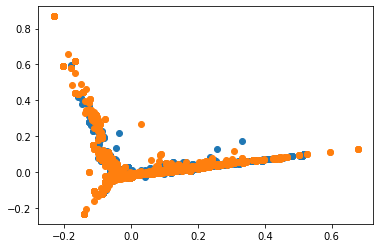

In [23]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

In [24]:
def translate_name_wav2vec(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
    pca = PCA(n_components=30)
    w_vec_pca = pca.fit_transform(w_vec) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(w_vec_pca.shape[1]):
        c_ = 'W_Name_' + str(i)
        df[c_] = w_vec_pca[:, i]
        
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
    return df1, df2

In [25]:
train_df_drop, test_df = translate_name_wav2vec(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [26]:
def translate_name_bert(df):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    c_name = hero.clean(df['Name'], pipeline=custom_pipeline)

    last_hidden_states_l = []
    for name in tqdm(c_name.values):
        input_ids = torch.tensor(tokenizer.encode(name, add_special_tokens=True)).unsqueeze(0) 
        outputs = model(input_ids)
        last_hidden_states_l.append(np.sum(outputs[0].to('cpu').detach().numpy().copy()[0], axis=0))

    last_hidden_states_np = np.array(last_hidden_states_l)

    pca = PCA(n_components=30)
    last_hidden_states_pca = pca.fit_transform(last_hidden_states_np) 
    #     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
    #     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(last_hidden_states_pca.shape[1]):
        c_ = 'B_Name_' + str(i)
        df[c_] = last_hidden_states_pca[:, i]
        
    return df

In [27]:
train_df_drop = translate_name_bert(train_df_drop)
test_df = translate_name_bert(test_df)

100%|██████████| 8360/8360 [04:34<00:00, 30.50it/s]


In [28]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Pub_Platform_Name_pca_0,Pub_Platform_Name_pca_1,...,B_Name_20,B_Name_21,B_Name_22,B_Name_23,B_Name_24,B_Name_25,B_Name_26,B_Name_27,B_Name_28,B_Name_29
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,48.983372,-21.987509,...,2.393954,-3.377572,-1.588892,-2.550547,-0.966077,-2.379960,-4.451659,4.856126,0.029626,0.870619
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,19.845629,2.303901,...,5.166783,-3.363069,0.301653,4.006661,4.000965,-1.724489,-1.376941,5.660968,1.045279,1.852443
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,48.983372,-21.987509,...,2.394243,-3.377261,-1.588805,-2.550601,-0.966257,-2.380170,-4.451389,4.856086,0.029539,0.870692
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,87.992511,-5.615959,...,0.445202,-0.823178,-0.134313,-0.969853,-1.778680,2.947633,0.318687,-0.198024,-0.065645,-0.750638
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,48.983372,-21.987509,...,0.403240,-7.200976,1.556282,4.506223,-0.100152,-0.682260,-1.592436,7.775301,-2.631423,-2.917969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,-3.029079,-0.973596,...,3.076055,-3.120832,0.090833,-1.616809,1.351152,5.964430,1.222015,-2.700890,-0.430601,0.653541
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,-3.591453,-0.481136,...,-7.050803,7.268128,3.809988,12.778027,-1.320103,4.565306,3.881395,8.735187,5.378200,7.567020
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,23.709706,23.341467,...,-0.080362,2.388784,-3.461710,-0.955446,-2.120549,2.765594,1.122877,-1.985645,1.243099,1.217930
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,146.907780,-5.172567,...,2.760510,-6.985860,-7.030567,2.754471,-1.208135,-4.694043,3.519949,-5.553657,-3.824654,4.058114


In [29]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [30]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [31]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [32]:

# kfoldの分割数
k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
               'max_dapth': 8,
              "learning_rate": 0.01,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(fold_ids):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.860964	valid_0's rmse: 1.19438
[400]	training's rmse: 0.727049	valid_0's rmse: 1.16703
[600]	training's rmse: 0.647719	valid_0's rmse: 1.16347
[800]	training's rmse: 0.591664	valid_0's rmse: 1.16043
[1000]	training's rmse: 0.548551	valid_0's rmse: 1.162
[1200]	training's rmse: 0.511269	valid_0's rmse: 1.16549
[1400]	training's rmse: 0.478864	valid_0's rmse: 1.16914
[1600]	training's rmse: 0.449177	valid_0's rmse: 1.17189
Early stopping, best iteration is:
[763]	training's rmse: 0.60073	valid_0's rmse: 1.15941
RMSLE_train: 0.6007295173999305, RMSLE_eval: 1.1594057656749048
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.864602	valid_0's rmse: 1.05137
[400]	training's rmse: 0.733326	valid_0's rmse: 1.00048
[600]	training's rmse: 0.65635	valid_0's rmse: 0.978225
[800]	training's rmse: 0.601407	valid_0's rmse: 0.968976
[1000]	training's rmse: 0.55859	valid_0's rms

In [33]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.9102895928435615


In [37]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof18.csv", index = False)

In [38]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [39]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub18.csv", index = False)

In [40]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

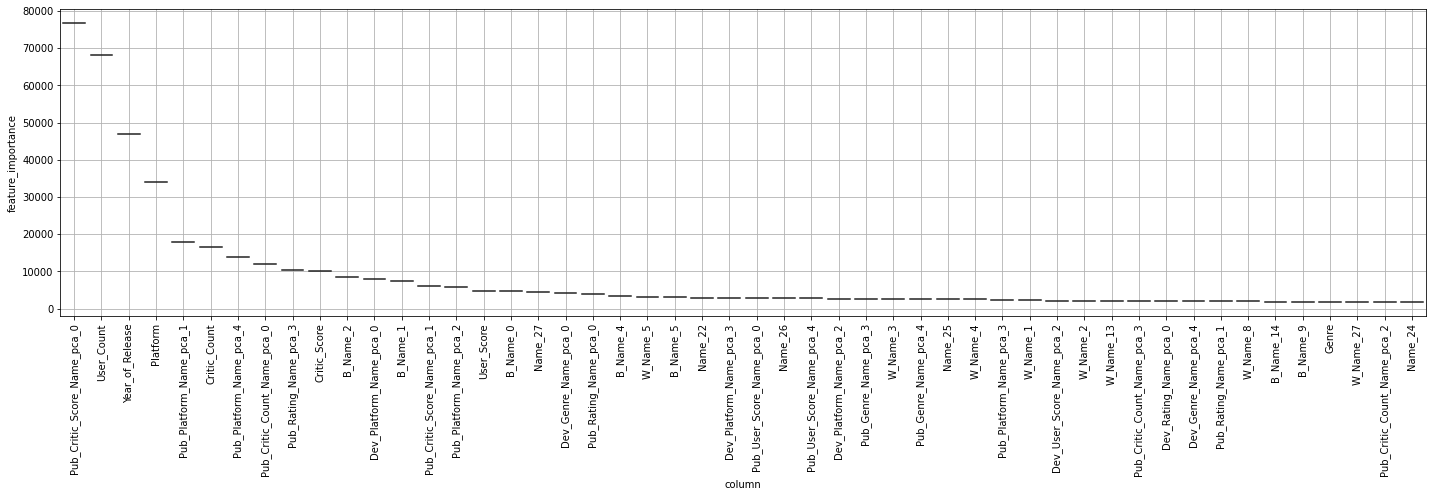

In [41]:
fig, ax = visualize_importance(model, X)


In [42]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Dev_Critic_Count_Name_pca_0,107.723102
Pub_Genre_Name_pca_1,125.347242
Name_2,131.143083
Dev_Critic_Score_Name_pca_4,136.227518
Dev_User_Count_Name_pca_1,184.601429
...,...
Pub_Platform_Name_pca_1,17921.597127
Platform,34007.074169
Year_of_Release,46919.736733
User_Count,68162.990931


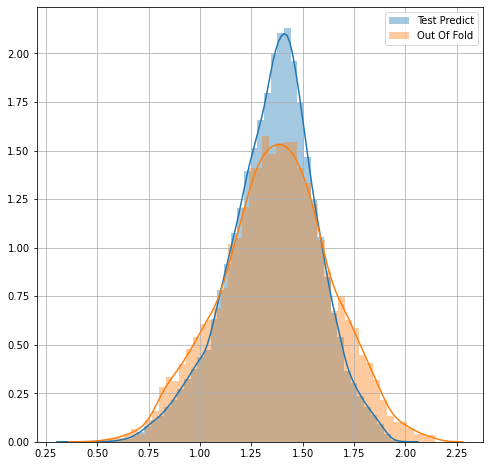

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

<AxesSubplot:>

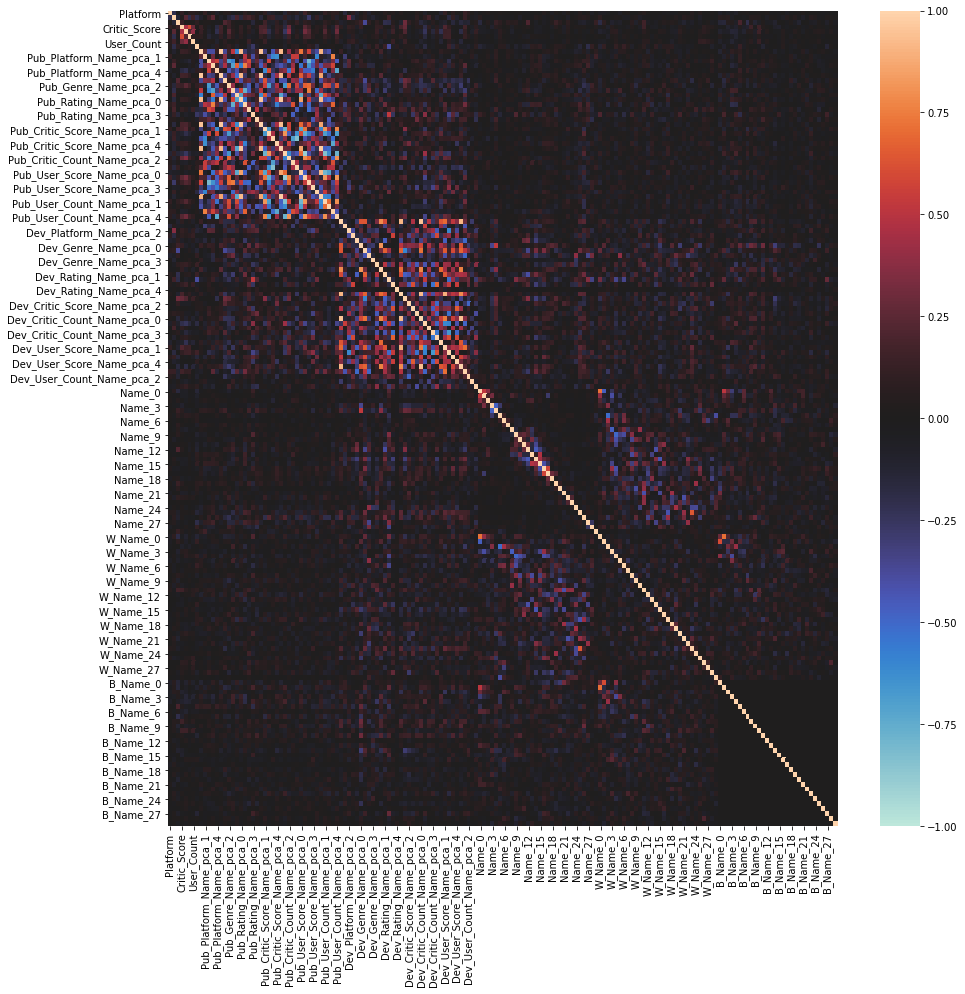

In [45]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df_drop.corr(), vmax=1, vmin=-1, center=0)
# train_df_drop.corr().style.background_gradient(axis=None)

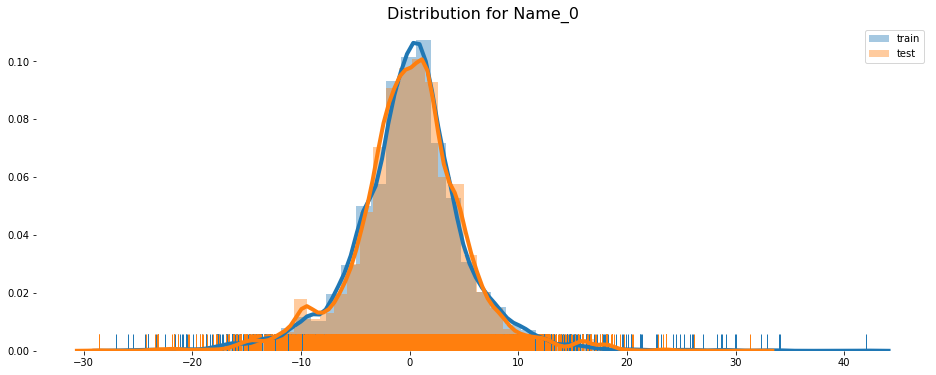

In [52]:
cols = 'Name_0'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop['B_Name_10'].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df['B_Name_10'].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()